In [3]:
import numpy as np
import PIL.Image
import tensorflow as tf

from cStringIO import StringIO
from IPython.display import  Image, display, HTML

In [5]:
MODEL_LOC='./InceptionModel/tensorflow_inception_graph.pb'
LABELS_LOC='./InceptionModel/imagenet_comp_graph_label_strings.txt'
def load_model():
  '''Loads the Inception (v1) model and creates a TensorFlow session
     for it.
  '''
  graph = tf.Graph()
  cfg = tf.ConfigProto(gpu_options={'allow_growth':True})
  sess = tf.InteractiveSession(graph=graph, config=cfg)
  graph_def = tf.GraphDef.FromString(open(MODEL_LOC).read())
  tf.import_graph_def(graph_def)
  return sess, graph

def T(layer):
  '''Helper for getting layer output tensor'''
  return graph.get_tensor_by_name("import/%s:0"%layer)

def run_network(sess, tensor, images):
  '''Helper for evaluating a tensor on a bunch of images
     within a session.
  '''
  imagenet_mean = 117.0
  return sess.run(tensor, {'import/input:0': [img - imagenet_mean for img in images]})

def top_label_and_score(img):
  '''Returns the label and score of the object class
     that receives the highest SOFTMAX score.

     The provided image must of shape (224, 224, 3)
  '''
  # Evaluate the SOFTMAX output layer for the image and
  # determine the label for the highest-scoring class
  t_softmax = tf.reduce_mean(T('softmax2'), reduction_indices=0)
  scores = run_network(sess, t_softmax, [img])
  id = np.argmax(scores)
  return labels[id], scores[id]

def output_label_tensor(label):
  '''Returns a tensor (shape: scalar) representing the SOFTMAX
     for a given label.
  '''
  lab_index = np.where(np.in1d(labels, [label]))[0][0]
  t_softmax = tf.reduce_mean(T('softmax2'), reduction_indices=0)
  return t_softmax[lab_index]

def gradients(img, label):
  '''Returns attributions for the prediction label based
     on just the gradients at the image.

     Specifically, the method returns the dot product of the image
     and the gradients of the provided prediction label (w.r.t. the
     image).

     The provided image must of shape (224, 224, 3), which is
     also the shape of the returned attributions tensor.
  '''
  t_output = output_label_tensor(label)  # shape: scalar
  t_grad = tf.gradients(t_output, T('input'))[0]
  grads = run_network(sess, t_grad, [img])
  return img*grads[0]

def integrated_gradients(img, label, steps=50):
  '''Returns attributions for the prediction label based
     on integrated gradients at the image.

     Specifically, the method returns the dot product of the image
     and the average of the gradients of the prediction label (w.r.t.
     the image) at uniformly spaced scalings of the provided image.

     The provided image must of shape (224, 224, 3), which is
     also the shape of the returned attributions tensor.
  '''
  t_output = output_label_tensor(label)  # shape: scalar
  t_grad = tf.gradients(t_output, T('input'))[0]
  scaled_images = [(float(i)/steps)*img for i in range(1, steps+1)]
  # Compute the gradients of the scaled images
  grads = run_network(sess, t_grad, scaled_images)
  return img*np.average(grads, axis=0)

def pil_img(a):
  '''Returns a PIL image created from the provided RGB array.
  '''
  a = np.uint8(a)
  return PIL.Image.fromarray(a)

def show_img(img, fmt='jpeg'):
  '''Displays the provided RGB image
  '''
  f = StringIO()
  img.save(f, fmt)
  display(Image(data=f.getvalue()))

def visualize_attrs(img, attrs, ptile=99):
   '''Visaualizes the provided attributions by first aggregating them
      along the color channel to obtain per-pixel attributions and then
      scaling the intensities of the pixels in the original image in
      proportion to these attributions.

      The provided image and attributions must of shape (224, 224, 3).
   '''
   pixel_attrs = np.sum(np.abs(attrs), axis=2)
   pixel_attrs = np.clip(pixel_attrs/np.percentile(pixel_attrs, ptile), 0,1)
   vis = img*np.transpose([pixel_attrs, pixel_attrs, pixel_attrs], axes=[1,2,0])
   show_img(pil_img(vis))

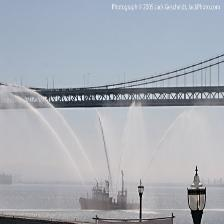

In [8]:
# Load the Inception model.
sess, graph = load_model()

# Load the labels vocabulary.
labels = np.array(open(LABELS_LOC).read().split('\n'))

# Load the image.
with open('./Images/70bfca4555cca92e.jpg') as f:
  img = f.read()
  img = sess.run(tf.image.decode_jpeg(img))
show_img(pil_img(img))

Top label: fireboat, score: 0.999984
Gradients at the Image


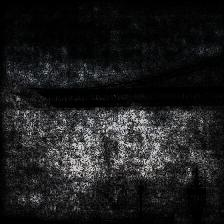

Integrated gradients


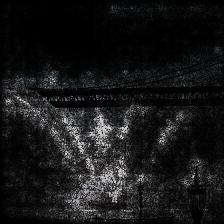

In [11]:
# Determine top label and score.
top_label, score = top_label_and_score(img)
print "Top label: %s, score: %f" % (top_label, score)

# Compute attributions based on just the gradients.
grads_attrs = gradients(img, top_label)
print "Gradients at the Image"
visualize_attrs(img, grads_attrs)

# Compute attributions based on the integrated gradients
# method.
intgrads_attrs = integrated_gradients(img, top_label)
print "Integrated gradients"
visualize_attrs(img, intgrads_attrs)